# Conformal Prediction

We will use conformalization techniques to characterize the uncertainty so that certain statistical guarantees can be provided for the predictions. Most importantly, we will predict sets (not points). A set is general mathematical object that subsumes both intervals, labels, and categories.

Further, conformal procedures allow us to tune classifiers in a much more principled way. The traditional way of tuning a classifier is to plot the ROC curves and pick an operating point. The levers typically are precision, recall, fpr, tpr, etc. 

Tuning a binary classifier is actually straightforward. But how does one pick a point or sets of points when there are more than two classes.  

Later we will see, the coverage probability and conformalization procedures turn this multivariate decision problem into a single variable decision problem. 

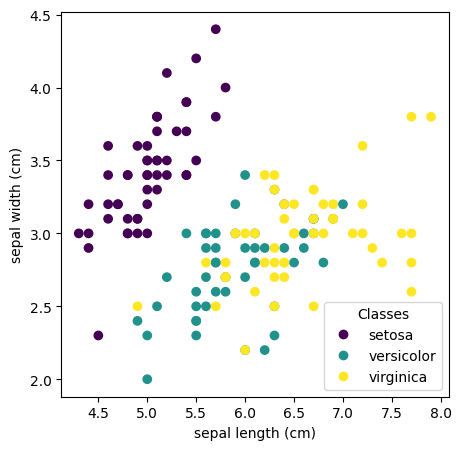

In [6]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# we will use only two features but all the classes
iris = load_iris()
y = iris.target
X = iris.data[:, 0:2]

# look at the data

import matplotlib.pyplot as plt
import numpy as np

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [7]:
from sklearn.model_selection import train_test_split

train_ratio = 0.70
calibration_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, shuffle=True)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + calibration_ratio),shuffle=True) 

print(X_train.shape, X_cal.shape, X_test.shape)
print(y_train.shape, y_cal.shape, y_test.shape)

(104, 2) (23, 2) (23, 2)
(104,) (23,) (23,)


In [8]:
# Fit a logistic regression model

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,multi_class='multinomial').fit(X_train, y_train)
yh_train = clf.predict(X_train)

from sklearn.metrics import classification_report
print('on train set')
print(classification_report(y_train, yh_train, target_names=iris.target_names))

yh_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_test, yh_test, target_names=iris.target_names))

on train set
              precision    recall  f1-score   support

      setosa       1.00      0.97      0.99        34
  versicolor       0.70      0.81      0.75        37
   virginica       0.75      0.64      0.69        33

    accuracy                           0.81       104
   macro avg       0.82      0.81      0.81       104
weighted avg       0.81      0.81      0.81       104

on test set
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         6
  versicolor       0.75      0.43      0.55         7
   virginica       0.69      0.90      0.78        10

    accuracy                           0.78        23
   macro avg       0.81      0.78      0.78        23
weighted avg       0.79      0.78      0.77        23



/opt/miniconda3/envs/ai839/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
# Implement Expected Calibration Error
# Ref: https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d)


def expected_calibration_error(samples, true_labels, M=5):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece

# ece on train set
pred_proba_train = clf.predict_proba(X_train)
ece_train = expected_calibration_error(pred_proba_train, y_train, M=10)
print('ece on train set',ece_train)

pred_proba_test = clf.predict_proba(X_test)
ece_test = expected_calibration_error(pred_proba_test, y_test, M=5)
print('ece on test set',ece_test)

ece on train set [0.07482647]
ece on test set [0.11760297]


In [11]:
# Wrap the trained classifier into PUNCC

# Create a wrapper of the random forest model to redefine its predict method
# into logits predictions. Make sure to subclass BasePredictor.
# Note that we needed to build a new wrapper (over BasePredictor) only because
# the predict(.) method of RandomForestClassifier does not predict logits.
# Otherwise, it is enough to use BasePredictor (e.g., neural network with softmax).

from deel.puncc.classification import RAPS
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.metrics import classification_mean_coverage
from deel.puncc.metrics import classification_mean_size

import numpy as np

class LogisticPredictor(BasePredictor):
    def predict(self, X, **kwargs):
        return self.model.predict_proba(X, **kwargs)


# Wrap model in the newly created RFPredictor
clf_predictor = LogisticPredictor(clf)


# CP method initialization
raps_cp = RAPS(clf_predictor, train=True, k_reg=2, lambd=0)

# The call to `fit` trains (with flag True) the model and computes the nonconformity
# scores on the calibration set
raps_cp.fit(X_fit=X_train, y_fit=y_train, X_calib=X_cal, y_calib=y_cal)


# The predict method infers prediction intervals with respect to
# the significance level alpha = 20%
y_pred, set_pred = raps_cp.predict(X_test, alpha=.1)

# Compute marginal coverage
coverage = classification_mean_coverage(y_test, set_pred)
size = classification_mean_size(set_pred)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average prediction set size: {np.round(size, 2)}")


Marginal coverage: 0.87
Average prediction set size: 1.7


/opt/miniconda3/envs/ai839/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [12]:
# Let us subset data s.t we will decide to predict if the set size is 1. o.w we will abstain
# for illustration, we will do it on train set.

from sklearn.metrics import accuracy_score
y_pred, set_pred = raps_cp.predict(X_train, alpha=.1)
ind = np.array([len(x)==1 for x in set_pred])

Xsub_train = X_train[ind,:]
ysub_train = y_train[ind]
yh_sub_train = clf.predict(Xsub_train)
acc_sub = accuracy_score(ysub_train,yh_sub_train)
acc = accuracy_score(y_train,clf.predict(X_train))
print('acc before', acc, 'acc after', acc_sub)


acc before 0.8076923076923077 acc after 0.9459459459459459


Text(0.5, 0, 'alpha')

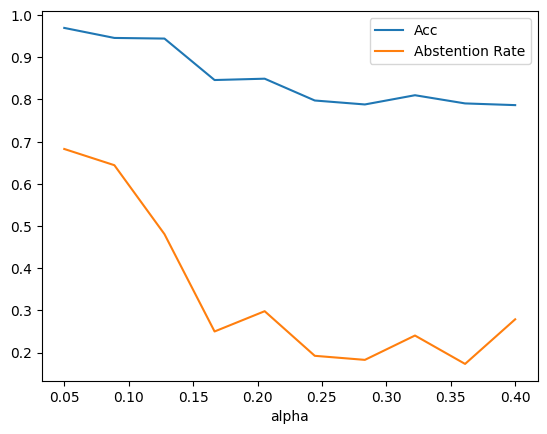

In [24]:
# we will vary alpha, compute accuracy on withheld sets
alphas = np.linspace(0.05,0.4,num=10)
acc_sub = []
rej_ratio = []
    
def get_acc(X,y, alpha):
    acc_sub = []
    rej_ratio = []
    y_pred, set_pred = raps_cp.predict(X, alpha=alpha)
    ind = np.array([len(x)==1 for x in set_pred])
    X_sub = X[ind,:]
    y_sub = y[ind]
    yh_sub = clf.predict(X_sub)
    acc = accuracy_score(y_sub,yh_sub)
    rej = 1-sum(ind)/len(ind)
    return acc, rej


for alpha in alphas:
    acc, rej = get_acc(X_train,y_train, alpha)
    acc_sub.append(acc)
    rej_ratio.append(rej)

plt.plot(alphas, acc_sub,label='Acc')
plt.plot(alphas, rej_ratio, label='Abstention Rate')
plt.legend()
plt.xlabel('alpha')

Text(0, 0.5, 'accuracy')

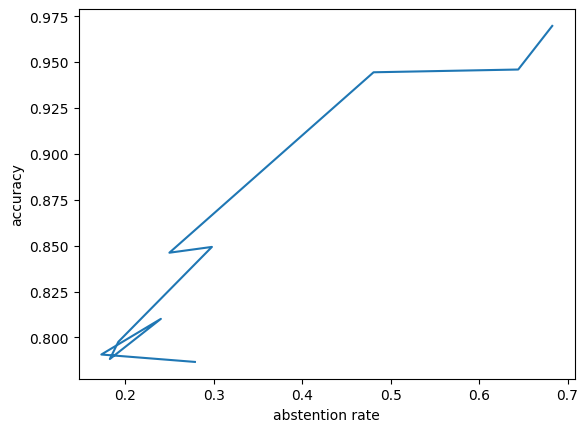

In [28]:
plt.plot(rej_ratio, acc_sub)
plt.xlabel('abstention rate')
plt.ylabel('accuracy')